## Part 1: Preprocessing

### Loading The Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_parquet('DMC-Train.parquet', engine='fastparquet')

In [3]:
test_df = pd.read_parquet('DMC-phase2-validation.parquet', engine='fastparquet')

### Unwrap JSON

In [4]:
import json

In [5]:
def unwrap_json(dataframe):
    post_df = pd.json_normalize(dataframe.post_data.apply(json.loads))
    post_df = post_df.drop(post_df.columns[15:], axis=1)
    dataframe = pd.concat([post_df, dataframe], axis=1)
    dataframe = dataframe.drop('post_data', axis=1)
    return dataframe

In [6]:
train_df = unwrap_json(train_df)

train_df['reject_reason_id'] = train_df['reject_reason_id'].map({
    0: 0, 5: 1, 12: 2, 13: 3, 29: 4, 139: 5, 145: 6, 146: 7, 163: 8
})

train_label = train_df[['reject_reason_id']].to_numpy().squeeze()

In [7]:
test_df = unwrap_json(test_df)

In [8]:
train_label.shape

(540362,)

### Categorical to One-Hot

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
def train_onehot(dataframe):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(dataframe)
    return enc

In [11]:
cat_columns = ['body_status', 'brand_model', 'color', 'document',
               'gearbox', 'selling_type', 'year', 'third_party_insurance_deadline']

In [12]:
onehot_model = train_onehot(train_df[cat_columns])

In [13]:
train_cat = onehot_model.transform(train_df[cat_columns])

In [14]:
test_cat = onehot_model.transform(test_df[cat_columns])

In [15]:
train_cat.shape

(540362, 1252)

### Numerical to Categorical

In [16]:
from scipy.sparse import hstack
import numpy as np

In [17]:
def train_num2cat(dataframe, num_bins):
    bins = pd.qcut(dataframe, duplicates='drop', q=num_bins, retbins=True)[1]
    bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))
    res_df = pd.cut(dataframe, bins).to_frame()
    oh_model = train_onehot(res_df)
    return bins, oh_model

In [18]:
def transform_num2cat(dataframe, model, bins):
    res_df = pd.cut(dataframe, bins).to_frame()
    return model.transform(res_df)

In [19]:
price_bins, price_model = train_num2cat(train_df['new_price'], 50)
usage_bins, usage_model = train_num2cat(train_df['usage'], 25)

In [20]:
train_price = transform_num2cat(train_df['new_price'], price_model, price_bins)
train_usage = transform_num2cat(train_df['usage'], usage_model, usage_bins)

In [21]:
train_price.shape

(540362, 51)

In [22]:
train_usage.shape

(540362, 23)

In [23]:
train_cat = hstack((train_cat, train_price, train_usage))

In [24]:
train_cat.shape

(540362, 1326)

In [25]:
test_price = transform_num2cat(test_df['new_price'], price_model, price_bins)
test_usage = transform_num2cat(test_df['usage'], usage_model, usage_bins)

In [26]:
test_cat = hstack((test_cat, test_price, test_usage))

### Cleaning Text Fields

In [27]:
import hazm
from hazm import Normalizer, WordTokenizer, Lemmatizer
import re
import pickle
import codecs

In [28]:
with open('my_translation_dict.pickle', 'rb') as handle:
    new_translation = pickle.load(handle)

In [32]:
with open('stopwords.dat') as handle:
    stopwords = handle.readlines()
    stopwords = [word[:-1] for word in stopwords]

In [29]:
class TextHandler:
    def __init__(self, persian_numbers=False,
                 change_lang_spacing=True,
                 remove_non_standard_char=True,
                 remove_repetitive_chars=True,
                 user_translations=None,
                 stopwords=None,
                 lemma=False
                ):
        
        # text preprocessing config
        if not persian_numbers:
            number_src = '۰۱۲۳۴۵۶۷۸۹٪'
            number_dest = '0123456789%'
        else:
            number_dest = '۰۱۲۳۴۵۶۷۸۹٪'
            number_src = '0123456789%'
        
        self.number_translations = self.maketrans(number_src, number_dest)
        
        if not user_translations:
            self.user_translations = dict()
        else:
            self.user_translations = user_translations

        self._remove_repetitive_chars = remove_repetitive_chars
        self._change_lang_spacing = change_lang_spacing
        self._remove_non_standard_char = remove_non_standard_char
        self._stopwords = stopwords
        
        self.text_normalizer = hazm.Normalizer(
            remove_extra_spaces=True,
            persian_style=False,
            persian_numbers=False,
            remove_diacritics=True,
            affix_spacing=True,
            token_based=False,
            punctuation_spacing=True)

        self.word_tokenizer = hazm.WordTokenizer(
            join_verb_parts=False,
            separate_emoji=True,
            replace_links=True,
            replace_IDs=False,
            replace_emails=True,
            replace_numbers=False,
            replace_hashtags=False)
        
        if lemma:
            self.lemmatizer = Lemmatizer()
        else:
            self.lemmatizer = None
        

    def normalize(self, text: str):
        text = text.translate(self.user_translations)
        text = text.translate(self.number_translations)
        
        text = text.lower()

        normalized_text = self.text_normalizer.normalize(text)

        if self._remove_repetitive_chars:
            text = self.remove_rep_chars(text)

        if self._change_lang_spacing:
            text = self.change_lang_spacing(text)

        if self._remove_non_standard_char:
            text = self.remove_non_standard_char(text)
            
        text = self.remove_stopwords_and_lemma(text)

        # reduce multiple spaces to one space
        text = re.sub(r'[\u200c\s]*\s[\s\u200c]*', ' ', text)
        text = re.sub(r'[\u200c]+', '\u200c', text)

        return text

    
    @staticmethod
    def maketrans(src_chars, dest_chars):
        return dict((ord(a), b) for a, b in zip(src_chars, dest_chars))
    
    @staticmethod
    def change_lang_spacing(text: str) -> str:
        return re.sub('(([a-zA-Z0-9/\-\.]+)|([ء-یژپچگ]+))', r' \1 ', text).strip()

    @staticmethod
    def remove_non_standard_char(text: str) -> str:
        # replace every junk character with space (all characters except Persian and English chars plus English digits)
        return re.sub(r'[^a-zA-Z0-9\u0621-\u06CC\u0698\u067E\u0686\u06AF]', ' ', text)

    @staticmethod
    def remove_rep_chars(text: str) -> str:
        return re.sub(r'([^0-9])\1\1+', r'\1', text)
    
    def remove_stopwords_and_lemma(self, text: str) -> str:
        if self.lemmatizer or self._stopwords:
            words = self.word_tokenizer.tokenize(text)
            if self._stopwords:
                words = [w for w in words if w not in self._stopwords]
            if self.lemmatizer:
                words = [self.lemmatizer.lemmatize(w) for w in words]
            return ' '.join(words)
        return text
    
    def preprocess_text(self, text: str):
        normalized_text = self.normalize(text)
        return normalized_text

In [30]:
text_handler = TextHandler(user_translations=new_translation)

In [31]:
train_df['prep_title'] = train_df['title'].apply(text_handler.preprocess_text)
train_df['prep_description'] = train_df['description'].apply(text_handler.preprocess_text)
train_df['prep_text'] = '<start> ' + train_df['prep_description'] + ' <delim> ' + train_df['prep_title'] + ' <end>'

In [32]:
test_df['prep_title'] = test_df['title'].apply(text_handler.preprocess_text)
test_df['prep_description'] = test_df['description'].apply(text_handler.preprocess_text)
test_df['prep_text'] = '<start> ' + test_df['prep_description'] + ' <delim> ' + test_df['prep_title'] + ' <end>'

In [33]:
train_texts = train_df['prep_text'].tolist()

In [34]:
test_texts = test_df['prep_text'].tolist()

### Text Length Distribution

In [35]:
import hazm
tokenizer = hazm.WordTokenizer(
            join_verb_parts=False,
            separate_emoji=True,
            replace_links=True,
            replace_IDs=False,
            replace_emails=True,
            replace_numbers=False,
            replace_hashtags=False
        )

In [36]:
train_t = [tokenizer.tokenize(t) for t in train_texts]
lens = [len(t) for t in train_t]

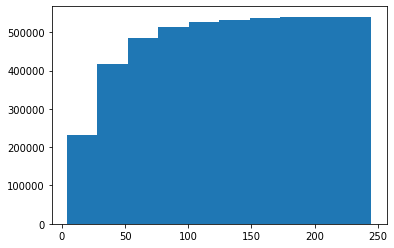

In [39]:
import matplotlib.pyplot as plt
plt.hist(lens, cumulative=True);

### Saving to File

In [40]:
from scipy.sparse import save_npz
import pickle

In [41]:
with open('train_texts.pkl', 'wb') as f:
    pickle.dump(train_texts, f)
    
save_npz("train_cat.npz", train_cat)

with open('train_label.npy', 'wb') as f:
    np.save(f, train_label)

In [42]:
with open('test_texts.pkl', 'wb') as f:
    pickle.dump(test_texts, f)
    
save_npz("test_cat.npz", test_cat)

### Loading from File

In [1]:
from scipy.sparse import load_npz
import pickle
import numpy as np

In [2]:
with open('train_texts.pkl', 'rb') as f:
    train_texts = pickle.load(f)
    
train_cat = load_npz("train_cat.npz")

with open('train_label.npy', 'rb') as f:
    train_label = np.load(f)

### Train-Validation Split

In [3]:
import math
import numpy as np

In [4]:
train_cat = train_cat.toarray()

In [5]:
np.random.seed(0)

In [6]:
train_len = len(train_texts)
indices = np.arange(train_len)
np.random.shuffle(indices, )
train_idx = indices[:math.floor(0.9*train_len)]
val_idx = indices[math.floor(0.9*train_len):]

In [7]:
val_texts = [train_texts[i] for i in val_idx]
val_cat = train_cat[val_idx]
val_label = train_label[val_idx]

In [8]:
train_texts = [train_texts[i] for i in train_idx]
train_cat = train_cat[train_idx]
train_label = train_label[train_idx]

### Creating PyTorch Datasets

In [9]:
import torch as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [10]:
class Vocabulary:
    def __init__(self, min_df):
        self.itos = {0: '<pad>', 1: '<unk>'}
        self.stoi = {'<pad>': 0, '<unk>': 1}
        self.min_df = min_df
        self.tokenizer = hazm.WordTokenizer(
            join_verb_parts=False,
            separate_emoji=True,
            replace_links=True,
            replace_IDs=False,
            replace_emails=True,
            replace_numbers=False,
            replace_hashtags=False
        )

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 2

        for sentence in sentence_list:
            for word in self.tokenizer.tokenize(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.min_df:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        
        tokenized_text = self.tokenizer.tokenize(text)
        numer_text = [
            self.stoi[token] if token in self.stoi else self.stoi['<unk>']
            for token in tokenized_text
        ]
        
        numer_text = numer_text[:118]
        numer_text += (118 - len(numer_text)) * [0]
        
        return numer_text

In [11]:
class DivarDataset(Dataset):
    def __init__(self, cat_mat, text_list, labels, vocab):
        self.cat_mat = cat_mat
        self.labels = labels
        self.vocab = vocab
            
        self.text_list = [self.vocab.numericalize(text) for text in text_list]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        cat_row = self.cat_mat[index]
        numer_text = self.text_list[index]
        label = self.labels[index]
        return T.tensor(cat_row, dtype=T.float32), T.tensor(numer_text), label

In [12]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        cat_rows = [item[0] for item in batch]
        cat_rows = T.vstack(cat_rows)
        numer_texts = [item[1] for item in batch]
        text_lengths = [text.shape[0] for text in numer_texts]
        numer_texts = pad_sequence(numer_texts, batch_first=True, padding_value=self.pad_idx)
        labels = [item[2] for item in batch]
        labels = T.tensor(labels, dtype=T.long)
        
        return cat_rows, numer_texts, labels, text_lengths

In [13]:
def get_loader(cat_mat, text_list, labels, vocab, batch_size=32, shuffle=True):
    
    dataset = DivarDataset(cat_mat, text_list, labels, vocab)
    
    pad_idx = dataset.vocab.stoi['<pad>']

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=Collate(pad_idx=pad_idx)
    )

    return loader

### Creating Loader Objects

In [14]:
import hazm

In [15]:
min_df=30
vocab = Vocabulary(min_df)
vocab.build_vocabulary(train_texts)

In [16]:
train_loader = get_loader(train_cat, train_texts, train_label, vocab, batch_size=950)

In [17]:
val_loader = get_loader(val_cat, val_texts, val_label, vocab, batch_size=128)

### Classifier

In [1]:
!git clone https://github.com/SHI-Labs/Compact-Transformers

Cloning into 'Compact-Transformers'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 418 (delta 218), reused 251 (delta 112), pack-reused 0
Receiving objects: 100% (418/418), 1.33 MiB | 222.00 KiB/s, done.
Resolving deltas: 100% (218/218), done.


In [4]:
!mv Compact-Transformers ct

In [18]:
import torch as T
import torch.nn as nn
from ct.src.text import text_cct_2

In [20]:
def seq_mask(seq_len, max_len):
    idx = T.arange(max_len).to(seq_len).repeat(seq_len.size(0), 1)
    mask = T.gt(seq_len.unsqueeze(1), idx).to(seq_len)
    return mask

In [21]:
class Classifier(nn.Module):
    def __init__(self, cat_dim, dict_dim):
        super().__init__()              
            
        self.transformer = text_cct_2(kernel_size=1, seq_len=116, padding_idx=0,
                                      vocab_size=dict_dim, num_classes=300, word_embedding_dim=300)
        
        self.cat_shrink = nn.Sequential(
            nn.Linear(cat_dim, 300),
            nn.Tanh(),            
        )
                
        self.fc = nn.Sequential(
            nn.Linear(600, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 9)
        )
                
        
    def forward(self, cat, text, mask):
        
        text_embed = T.tanh(self.transformer(text, mask))

        cat_shrinked = self.cat_shrink(cat)
        
        lin_input = T.cat((cat_shrinked, text_embed), dim=1)
        
        return self.fc(lin_input)

In [22]:
CAT_DIM = train_cat.shape[1]
DICT_DIM = vocab.__len__()
model = Classifier(CAT_DIM, DICT_DIM)

### Training

In [23]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import time
import math
import torch.nn.functional as F

In [24]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=T.tensor([1.0, 2.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 3.0]))

In [25]:
device = 'cuda'
criterion = criterion.to(device)
model = model.to(device)

In [26]:
def binary_accuracy(preds, y):
    rounded_preds = T.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
        
    for i, (cat, text, label, text_lengths) in enumerate(iterator):
        
        if i % 500 == 0:
            print(f'    mini-batch {i}')
        
        optimizer.zero_grad()
        
        cat = cat.to(device)
        text = text.to(device)
        label = label.to(device)
        
        mask = seq_mask(T.tensor(text_lengths), 118).to(device)
        
        predictions = model(cat, text, mask)
        loss = criterion(predictions, label)
        
        softmax_predictions = F.softmax(predictions, dim=1)
        binary_predictions = 1 - softmax_predictions[:, 0]
        binary_label = (label != 0).float()
        acc = binary_accuracy(binary_predictions, binary_label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item() * len(text)
        epoch_acc += acc.item() * len(text)
                
    return epoch_loss / len(iterator.dataset), epoch_acc / len(iterator.dataset)

In [28]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    preds = []
    labels = []
    
    
    with T.no_grad():
    
        for i, (cat, text, label, text_lengths) in enumerate(iterator):

            cat = cat.to(device)
            text = text.to(device)
            label = label.to(device)
            
            mask = seq_mask(T.tensor(text_lengths), 118).to(device)
        
            predictions = model(cat, text, mask).squeeze(1)
                            
            loss = criterion(predictions, label)
            
            softmax_predictions = F.softmax(predictions, dim=1)
            binary_predictions = 1 - softmax_predictions[:, 0]
            binary_label = (label != 0).float()
            acc = binary_accuracy(binary_predictions, binary_label)
            
            preds += binary_predictions.tolist()
            labels += binary_label.tolist()

            epoch_loss += loss.item() * len(text)
            epoch_acc += acc.item() * len(text)
            
    auc = roc_auc_score(labels, preds)
        
    return epoch_loss / len(iterator.dataset), epoch_acc / len(iterator.dataset), auc

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
def adjust_lr(optimizer, epoch, warmup=4, epochs=12, lr=0.001):
    if epoch < warmup:
        lr = lr / (warmup - epoch)
    else:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup) / (epochs - warmup)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

CCT2, emb=300, word=300, layer=2, conv_pool=true, class_token, lr=0.0005, batch=450, Adam

In [31]:
N_EPOCHS = 12

for epoch in range(N_EPOCHS):

    print(f'Epoch: {epoch+1}')
    
    start_time = time.time()
    
    adjust_lr(optimizer, epoch)
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_auc = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    T.save(model.state_dict(), f'360_{epoch}.torch')
    T.save(optimizer.state_dict(), 'optim_360_{epoch}.torch')

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
       
    print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'    Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'     Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Val. AUC: {valid_auc:.4f}')
    print()

Epoch: 1
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 41s
    Train Loss: 0.922 | Train Acc: 82.11%
     Val. Loss: 0.636 |  Val. Acc: 88.38% | Val. AUC: 0.9259

Epoch: 2
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 41s
    Train Loss: 0.597 | Train Acc: 88.30%
     Val. Loss: 0.574 |  Val. Acc: 90.23% | Val. AUC: 0.9366

Epoch: 3
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 41s
    Train Loss: 0.543 | Train Acc: 89.16%
     Val. Loss: 0.524 |  Val. Acc: 89.36% | Val. AUC: 0.9413

Epoch: 4
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 42s
    Train Loss: 0.522 | Train Acc: 89.81%
     Val. Loss: 0.509 |  Val. Acc: 90.95% | Val. AUC: 0.9466

Epoch: 5
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 43s
    Train Loss: 0.474 | Train Acc: 90.94%
     Val. Loss: 0.484 |  Val. Acc: 91.34% | Val. AUC: 0.9502

Epoch: 6
    mini-batch 0
    mini-batch 500
Epoch Time: 7m 42s
    Train Loss: 0.436 | Train Acc: 91.78%
     Val. Loss: 0.463 |  Val. Acc: 92.00% | Val. AUC: 

### Evaluation

In [39]:
def predict(model, iterator):
    
    model.eval()
    
    preds = []
    labels = []
    
    
    with T.no_grad():
    
        for i, (cat, text, label, text_lengths) in enumerate(iterator):

            cat = cat.to(device)
            text = text.to(device)
            label = label.to(device)

            mask = seq_mask(T.tensor(text_lengths), 256).to(device)
            
            predictions = model(cat, text, mask).squeeze(1)        
            predictions = T.max(predictions, dim=1)[1]
            
            preds += predictions.tolist()
            labels += label.tolist()
        
    return preds, labels

In [40]:
from sklearn.metrics import classification_report

In [41]:
preds, labels = predict(model, val_loader)

0: 0, 5: 1, 12: 2, 13: 3, 29: 4, 139: 5, 145: 6, 146: 7, 163: 8

In [43]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     41471
           1       0.79      0.84      0.81       170
           2       0.83      0.89      0.86      2740
           3       0.80      0.80      0.80      2143
           4       0.69      0.59      0.64       137
           5       0.53      0.61      0.57      2158
           6       0.95      0.95      0.95      2702
           7       0.75      0.71      0.73       267
           8       0.70      0.70      0.70      2249

    accuracy                           0.91     54037
   macro avg       0.78      0.78      0.78     54037
weighted avg       0.92      0.91      0.91     54037



### Saving The Model

In [44]:
T.save(model.state_dict(), 'transformer.torch')
T.save(optimizer.state_dict(), 'transformer_optim.torch')

In [32]:
with open('vocab_stoi.pkl', 'wb') as f:
    pickle.dump(vocab.stoi, f)

In [33]:
with open('vocab_itos.pkl', 'wb') as f:
    pickle.dump(vocab.itos, f)

In [34]:
print(CAT_DIM, DICT_DIM)

1326 9654


### Loading Test Data & The Model

In [125]:
from scipy.sparse import load_npz
import pickle
import hazm
import numpy as np

In [64]:
with open('test_texts.pkl', 'rb') as f:
    test_texts = pickle.load(f)
    
test_cat = load_npz("test_cat.npz")

In [65]:
test_cat = test_cat.toarray()

In [53]:
with open('vocab_stoi.pkl', 'rb') as f:
    vocab_stoi = pickle.load(f)

with open('vocab_itos.pkl', 'rb') as f:
    vocab_itos = pickle.load(f)

In [12]:
vocab = Vocabulary(30)
vocab.stoi = vocab_stoi
vocab.itos = vocab_itos

In [66]:
test_loader = get_loader(test_cat, test_texts, np.zeros(len(test_texts)), vocab, batch_size=64, shuffle=False)

In [14]:
CAT_DIM = 1371 
DICT_DIM = 9589
EMBEDDING_DIM = 300
HIDDEN_DIM = 400
dropout = 0.3

model = Classifier(CAT_DIM, DICT_DIM, EMBEDDING_DIM, HIDDEN_DIM, dropout)
model.load_state_dict(T.load('transformer.torch'))

<All keys matched successfully>

In [ ]:
optimizer.load_state_dict(T.load('transformer_optim.torch'))

In [15]:
device = 'cuda'
model = model.to(device)

### Predicting

In [67]:
import pandas as pd

In [71]:
def predict(model, iterator):
    
    model.eval()
    
    preds = []
    
    with T.no_grad():
        for i, (cat, text, label, text_lengths) in enumerate(iterator):

            cat = cat.to(device)
            text = text.to(device)
            
            mask = seq_mask(T.tensor(text_lengths), 256).to(device)
            
            predictions = model(cat, text, mask)
            
            softmax_predictions = F.softmax(predictions, dim=1)
            binary_predictions = 1 - softmax_predictions[:, 0]
            
            preds += binary_predictions.tolist()
        
    return preds

In [72]:
preds = predict(model, test_loader)

<ipython-input-12-3d3759029939>:12: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = T.tensor(labels, dtype=T.long)


In [73]:
preds = [1 - p for p in preds]

In [74]:
test_df = pd.read_parquet('DMC-phase2-validation.parquet', engine='fastparquet')
pred_df = pd.DataFrame()
pred_df['post_id'] = test_df['post_id']
pred_df['predictions'] = preds

In [75]:
pred_df.head(5)

,post_id,predictions
0,c16685db-c7b2-403e-b56d-4a745d7e4686,0.981617
1,e65f2de9-acd2-4f03-9395-24f89e1fed32,0.228582
2,cdf973fe-0b45-49d5-b5d6-bbca65c87adc,0.004238
3,e29d3726-6f7e-42f2-9684-26f1cd3405f8,0.988345
4,37fb59d9-be82-4985-84ed-9132732b2144,0.001131


In [76]:
pred_df.to_csv('pred.csv', index=False)